# Tensorflow Multi-GPU VAE-GAN implementation

- This is an implementation of the VAE-GAN based on the implementation described in *<a href="http://arxiv.org/abs/1512.09300">Autoencoding beyond pixels using a learned similarity metric</a>*
- I implement a few useful things like
  - Visualizing Movement Through Z-Space
  - Latent Space Algebra
  - Spike Triggered Average Style Receptive Fields

### How does a VAE-GAN work?
- We have three networks, an  <font color="#38761d"><strong>Encoder</strong></font>,
a <font color="#1155cc"><strong>Generator</strong></font>, and a <font color="#ff0000"><strong>Discriminator</strong></font>. 
    - The <font color="#38761d"><strong>Encoder</strong></font> learns to map input x onto z space (latent space)
    - The <font color="#1155cc"><strong>Generator</strong></font> learns to generate x from z space
    - The <font color="#ff0000"><strong>Discriminator</strong></font> learns to discriminate whether the image being put in is real, or generated

### Diagram of basic network input and output

![vae gan outline](network_outline.png)

### `l_x_tilde` and `l_x` here become layers of *high level features* that the discriminator learns. 
- we train the network to minimize the difference between the high level features of `x` and `x_tilde`
- This is basically an autoencoder that works on *high level features* rather than pixels
- Adding this *autoencoder* to a GAN helps to stabilize the GAN

### Training
Train <font color="#38761d"><strong>Encoder</strong></font> on minimization of:
- `kullback_leibler_loss(z_x, gaussian)`
- `mean_squared_error(l_x_tilde_, l_x)`

Train <font color="#1155cc"><strong>Generator</strong></font> on minimization of:
- `kullback_leibler_loss(z_x, gaussian)`
- `mean_squared_error(l_x_tilde_, l_x)`
- `-1*log(d_x_p)`

Train <font color="#ff0000"><strong>Discriminator</strong></font> on minimization of:
- `-1*log(d_x) + log(1 - d_x_p)`


In [1]:
# Import all of our packages

import os
import numpy as np
import prettytensor as pt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from deconv import deconv2d
import IPython.display
import math
import tqdm # making loops prettier
import h5py # for reading our dataset
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed

%matplotlib inline  

## Parameters 


In [2]:
dim1 = 64 # first dimension of input data
dim2 = 64 # second dimension of input data
dim3 = 3 # third dimension of input data (colors)
batch_size = 32 # size of batches to use (per GPU)
hidden_size = 2048 # size of hidden (z) layer to use
num_examples = 60000 # how many examples are in your training set
num_epochs = 10000 # number of epochs to run
### we can train our different networks  with different learning rates if we want to
e_learning_rate = 1e-3
g_learning_rate = 1e-3
d_learning_rate = 1e-3

### Which GPUs are we using?
- Set `gpus` to a list of the GPUs you're using. The network will then split up the work between those gpus

In [3]:
gpus = [2] # Here I set CUDA to only see one GPU
os.environ["CUDA_VISIBLE_DEVICES"]=','.join([str(i) for i in gpus])
num_gpus = len(gpus) # number of GPUs to use

### Reading the dataset from HDF5 format
- open `makedataset.ipynb' for instructions on how to build the dataset

In [4]:
with h5py.File(''.join(['datasets/faces_dataset_new.h5']), 'r') as hf:
    faces = hf['images'].value
    headers = hf['headers'].value
    labels = hf['label_input'].value

In [5]:
# Normalize the dataset between 0 and 1
faces = (faces/255.)

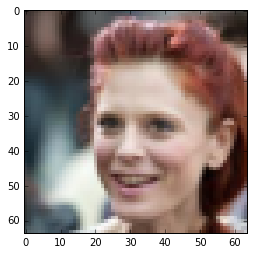

In [6]:
# Just taking a look and making sure everything works
plt.imshow(np.reshape(faces[1], (64,64,3)), interpolation='nearest')

In [7]:
# grab the faces back out after we've flattened them
def create_image(im):
    return np.reshape(im,(dim1,dim2,dim3))

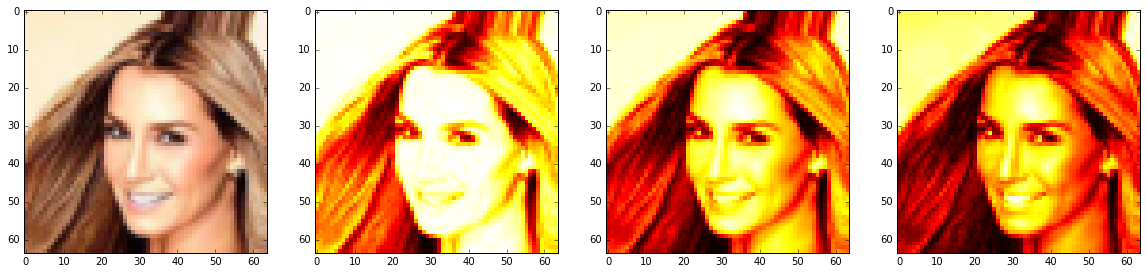

In [8]:
# Lets just take a look at our channels
cm = plt.cm.hot
test_face = faces[0].reshape(dim1,dim2,dim3)
fig, ax = plt.subplots(nrows=1,ncols=4, figsize=(20,8))
ax[0].imshow(create_image(test_face), interpolation='nearest')
ax[1].imshow(create_image(test_face)[:,:,0], interpolation='nearest', cmap=cm)
ax[2].imshow(create_image(test_face)[:,:,1], interpolation='nearest', cmap=cm)
ax[3].imshow(create_image(test_face)[:,:,2], interpolation='nearest', cmap=cm)

### A data iterator for batching (drawn up by Luke Metz)
- https://indico.io/blog/tensorflow-data-inputs-part1-placeholders-protobufs-queues/


In [9]:
def data_iterator():
    """ A simple data iterator """
    batch_idx = 0
    while True:
        idxs = np.arange(0, len(faces))
        np.random.shuffle(idxs)
        for batch_idx in range(0, len(faces), batch_size):
            cur_idxs = idxs[batch_idx:batch_idx+batch_size]
            images_batch = faces[cur_idxs]
            #images_batch = images_batch.astype("float32")
            labels_batch = labels[cur_idxs]
            yield images_batch, labels_batch

            
iter_ = data_iterator()

In [10]:
iter_ = data_iterator()

In [11]:
#face_batch, label_batch

### Bald people

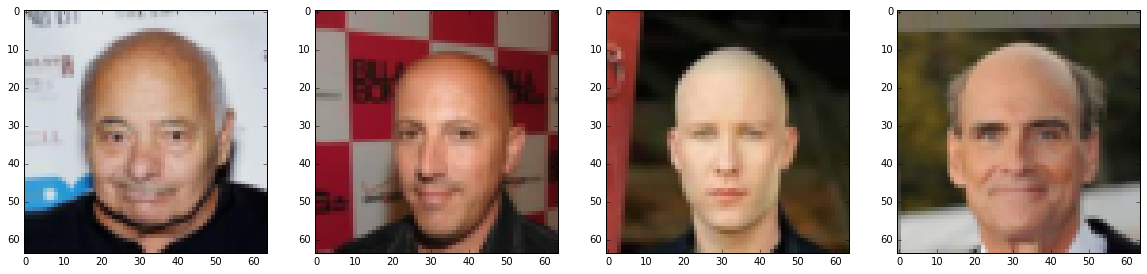

In [12]:
fig, ax = plt.subplots(nrows=1,ncols=4, figsize=(20,8))
ax[0].imshow(create_image(faces[labels[:,4] == 1][0]), interpolation='nearest')
ax[1].imshow(create_image(faces[labels[:,4] == 1][1]), interpolation='nearest')
ax[2].imshow(create_image(faces[labels[:,4] == 1][2]), interpolation='nearest')
ax[3].imshow(create_image(faces[labels[:,4] == 1][3]), interpolation='nearest')

### Draw out the architecture of our network
- Each of these functions represent the <font color="#38761d"><strong>Encoder</strong></font>,
<font color="#1155cc"><strong>Generator</strong></font>, and <font color="#ff0000"><strong>Discriminator</strong></font> described above. 
- It would be interesting to try and implement the inception architecture to do the same thing, next time around:
<br /><br />
![inception architecture](https://raw.githubusercontent.com/google/prettytensor/master/inception_module.png)
- They describe how to implement inception, in prettytensor, here: https://github.com/google/prettytensor

In [13]:
def encoder(X):
    '''Create encoder network.
    Args:
        x: a batch of flattened images [batch_size, 28*28]
    Returns:
        A tensor that expresses the encoder network
            # The transformation is parametrized and can be learned.
            # returns network output, mean, setd
    '''
    lay_end = (pt.wrap(X).
            reshape([batch_size, dim1, dim2, dim3]). 
            conv2d(5, 64, stride=2). 
            conv2d(5, 128, stride=2). 
            conv2d(5, 256, stride=2). 
            flatten())
    z_mean = lay_end.fully_connected(hidden_size, activation_fn=None)
    z_log_sigma_sq = lay_end.fully_connected(hidden_size, activation_fn=None)
    return z_mean, z_log_sigma_sq


def generator(Z):
    '''Create generator network.
        If input tensor is provided then decodes it, otherwise samples from 
        a sampled vector.
    Args:
        x: a batch of vectors to decode
    Returns:
        A tensor that expresses the generator network
    '''
    return (pt.wrap(Z).
            fully_connected(8*8*256).reshape([batch_size, 8, 8, 256]). #(128, 4 4, 256)
            deconv2d(5, 256, stride=2).
            deconv2d(5, 128, stride=2).
            deconv2d(5, 32, stride=2).
            deconv2d(1, dim3, stride=1, activation_fn=tf.sigmoid).
            flatten()
           )



def discriminator(D_I):
    ''' A encodes
    Create a network that discriminates between images from a dataset and
    generated ones.
    Args:
        input: a batch of real images [batch, height, width, channels]
    Returns:
        A tensor that represents the network
    ''' 
    descrim_conv =  (pt.wrap(D_I). # This is what we're descriminating
            reshape([batch_size, dim1, dim2, dim3]).
            conv2d(5, 32, stride=1).
            conv2d(5, 128, stride=2).
            conv2d(5, 256, stride=2).
            conv2d(5, 256, stride=2).
            flatten()
            )
    lth_layer= descrim_conv.fully_connected(1024, activation_fn=tf.nn.elu)# this is the lth layer       
    D =lth_layer.fully_connected(1, activation_fn=tf.nn.sigmoid) # this is the actual discrimination
    return D, lth_layer


### Defining the forward pass through the network
- This function is based upon the inference function from tensorflows cifar tutorials
  - https://github.com/tensorflow/tensorflow/blob/r0.10/tensorflow/models/image/cifar10/cifar10.py
- Notice I use `with tf.variable_scope("enc")`. This way, we can reuse these variables using `reuse=True`. We can also specify which variables to train using which error functions based upon the label `enc`

In [14]:
def inference(x):
    """
    Run the models. Called inference because it does the same thing as tensorflow's cifar tutorial
    """
    z_p =  tf.random_normal((batch_size, hidden_size), 0, 1) # normal dist for GAN
    eps = tf.random_normal((batch_size, hidden_size), 0, 1) # normal dist for VAE

    with pt.defaults_scope(activation_fn=tf.nn.elu,
                               batch_normalize=True,
                               learned_moments_update_rate=0.0003,
                               variance_epsilon=0.001,
                               scale_after_normalization=True):
        
        with tf.variable_scope("enc"):         
                z_x_mean, z_x_log_sigma_sq = encoder(x) # get z from the input      
        with tf.variable_scope("gen"):
            z_x = tf.add(z_x_mean, 
                tf.mul(tf.sqrt(tf.exp(z_x_log_sigma_sq)), eps)) # grab our actual z
            x_tilde = generator(z_x)  
        with tf.variable_scope("dis"):   
            _, l_x_tilde = discriminator(x_tilde)
        with tf.variable_scope("gen", reuse=True):         
            x_p = generator(z_p)    
        with tf.variable_scope("dis", reuse=True):
            d_x, l_x = discriminator(x)  # positive examples              
        with tf.variable_scope("dis", reuse=True):
            d_x_p, _ = discriminator(x_p)  
        return z_x_mean, z_x_log_sigma_sq, z_x, x_tilde, l_x_tilde, x_p, d_x, l_x, d_x_p, z_p

### Loss - define our various loss functions
- **SSE** - we don't actually use this loss (also its the MSE), its just to see how close x is to x_tilde
- **KL Loss** - our VAE gaussian distribution loss. 
  - See https://arxiv.org/abs/1312.6114
- **D_loss** - Our descriminator loss, how good the discriminator is at telling if something is real
- **G_loss** - essentially the opposite of the D_loss, how good the generator is a tricking the discriminator
- ***notice we clip our values to make sure learning rates don't explode***

In [15]:
def loss(x, x_tilde, z_x_log_sigma_sq, z_x_mean, d_x, d_x_p, l_x, l_x_tilde, dim1, dim2, dim3):
    """
    Loss functions for SSE, KL divergence, Discrim, Generator, Lth Layer Similarity
    """
    ### We don't actually use SSE (MSE) loss for anything (but maybe pretraining)
    SSE_loss = tf.reduce_mean(tf.square(x - x_tilde)) # This is what a normal VAE uses

    # We clip gradients of KL divergence to prevent NANs
    KL_loss = tf.reduce_sum(-0.5 * tf.reduce_sum(1 + tf.clip_by_value(z_x_log_sigma_sq, -10.0, 10.0) 
                                   - tf.square(tf.clip_by_value(z_x_mean, -10.0, 10.0) ) 
                                   - tf.exp(tf.clip_by_value(z_x_log_sigma_sq, -10.0, 10.0) ), 1))/dim1/dim2/dim3
    # Discriminator Loss
    D_loss = tf.reduce_mean(-1.*(tf.log(tf.clip_by_value(d_x,1e-5,1.0)) + 
                                    tf.log(tf.clip_by_value(1.0 - d_x_p,1e-5,1.0))))
    # Generator Loss    
    G_loss = tf.reduce_mean(-1.*(tf.log(tf.clip_by_value(d_x_p,1e-5,1.0))))# + 
                                    #tf.log(tf.clip_by_value(1.0 - d_x,1e-5,1.0))))
    # Lth Layer Loss - the 'learned similarity measure'  
    LL_loss = tf.reduce_sum(tf.square(l_x - l_x_tilde))/dim1/dim2/dim3
    return SSE_loss, KL_loss, D_loss, G_loss, LL_loss

### Average the gradients between towers
- This function is taken directly from 
    - https://github.com/tensorflow/tensorflow/blob/r0.10/tensorflow/models/image/cifar10/cifar10_multi_gpu_train.py
- Basically we're taking a list of gradients from each tower, and averaging them together

In [16]:
def average_gradients(tower_grads):
    """Calculate the average gradient for each shared variable across all towers.
    Note that this function provides a synchronization point across all towers.
    Args:
    tower_grads: List of lists of (gradient, variable) tuples. The outer list
      is over individual gradients. The inner list is over the gradient
      calculation for each tower.
    Returns:
     List of pairs of (gradient, variable) where the gradient has been averaged
     across all towers.
     
     
    """
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        # Note that each grad_and_vars looks like the following:
        #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
            # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)

            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(0, grads)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads


### Plot network output
- This is just my ugly function to regularly plot the output of my network - tensorboard would probably be a better option for this

In [70]:
def plot_network_output():
    """ Just plots the output of the network, error, reconstructions, etc
    """
    random_x, recon_z, all_d= sess.run((x_p, z_x_mean, d_x_p), {all_input: example_data})
    top_d = np.argsort(np.squeeze(all_d))
    recon_x = sess.run((x_tilde), {z_x: recon_z})
    examples = 8
    random_x = np.squeeze(random_x)
    recon_x = np.squeeze(recon_x)
    random_x = random_x[top_d]

    fig, ax = plt.subplots(nrows=3,ncols=examples, figsize=(18,6))
    for i in xrange(examples):
        ax[(0,i)].imshow(create_image(random_x[i]), cmap=plt.cm.gray, interpolation='nearest')
        ax[(1,i)].imshow(create_image(recon_x[i]), cmap=plt.cm.gray, interpolation='nearest')
        ax[(2,i)].imshow(create_image(example_data[i + (num_gpus-1)*batch_size]), cmap=plt.cm.gray, interpolation='nearest')
        ax[(0,i)].axis('off')
        ax[(1,i)].axis('off')
        ax[(2,i)].axis('off')
    fig.suptitle('Top: random points in z space | Bottom: inputs | Middle: reconstructions')
    plt.show()
    #fig.savefig(''.join(['imgs/test_',str(epoch).zfill(4),'.png']),dpi=100)
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,10), linewidth = 4)
    KL_plt, = plt.semilogy((KL_loss_list), linewidth = 4, ls='-', color='r', alpha = .5, label='KL')
    D_plt, = plt.semilogy((D_loss_list),linewidth = 4, ls='-', color='b',alpha = .5, label='D')
    G_plt, = plt.semilogy((G_loss_list),linewidth = 4, ls='-', color='k',alpha = .5, label='G')
    SSE_plt, = plt.semilogy((SSE_loss_list),linewidth = 4,ls='-', color='g',alpha = .5, label='SSE')
    LL_plt, = plt.semilogy((LL_loss_list),linewidth = 4,ls='-', color='m',alpha = .5, label='LL')
    
    axes = plt.gca()
    leg = plt.legend(handles=[KL_plt, D_plt, G_plt, SSE_plt, LL_plt], fontsize=20)
    leg.get_frame().set_alpha(0.5)
    plt.show()
    

In [19]:
graph = tf.Graph()

In [20]:
# Make lists to save the losses to 
# You should probably just be using tensorboard to do any visualization(or just use tensorboard...)
G_loss_list = [] 
D_loss_list = [] 
SSE_loss_list = []
KL_loss_list = []
LL_loss_list = []
dxp_list = []
dx_list = []

### With your graph, define what a step is (needed for multi-gpu), and what your optimizers are for each of your networks

In [21]:
with graph.as_default():
    #with tf.Graph().as_default(), tf.device('/cpu:0'):
    # Create a variable to count number of train calls
    global_step = tf.get_variable(
        'global_step', [],
        initializer=tf.constant_initializer(0), trainable=False)


    # different optimizers are needed for different learning rates (using the same learning rate seems to work fine though)
    lr_D = tf.placeholder(tf.float32, shape=[])
    lr_G = tf.placeholder(tf.float32, shape=[])
    lr_E = tf.placeholder(tf.float32, shape=[])
    opt_D = tf.train.AdamOptimizer(lr_D, epsilon=1.0)
    opt_G = tf.train.AdamOptimizer(lr_G, epsilon=1.0)
    opt_E = tf.train.AdamOptimizer(lr_E, epsilon=1.0)

### Run all of the functions we defined above
- `tower_grads_e` defines the list of gradients for the encoder for each tower
- For each GPU we grab parameters corresponding to each network, we then calculate the gradients, and add them to the twoers to be averaged


In [22]:
with graph.as_default():

    # These are the lists of gradients for each tower 
    tower_grads_e = []
    tower_grads_g = []
    tower_grads_d = []

    all_input = tf.placeholder(tf.float32, [batch_size*num_gpus, dim1*dim2*dim3])
    KL_param = tf.placeholder(tf.float32)
    LL_param = tf.placeholder(tf.float32)
    G_param = tf.placeholder(tf.float32)


    # Define the network for each GPU
    for i in xrange(num_gpus):
          with tf.device('/gpu:%d' % i):
                with tf.name_scope('Tower_%d' % (i)) as scope:
                    # grab this portion of the input
                    next_batch = all_input[i*batch_size:(i+1)*batch_size,:]

                    # Construct the model
                    z_x_mean, z_x_log_sigma_sq, z_x, x_tilde, l_x_tilde, x_p, d_x, l_x, d_x_p, z_p = inference(next_batch)

                    # Calculate the loss for this tower   
                    SSE_loss, KL_loss, D_loss, G_loss, LL_loss = loss(next_batch, x_tilde, z_x_log_sigma_sq, z_x_mean, d_x, d_x_p, l_x, l_x_tilde, dim1, dim2, dim3)

                    # specify loss to parameters
                    params = tf.trainable_variables()
                    E_params = [i for i in params if 'enc' in i.name]
                    G_params = [i for i in params if 'gen' in i.name]
                    D_params = [i for i in params if 'dis' in i.name]

                    # Calculate the losses specific to encoder, generator, decoder
                    L_e = tf.clip_by_value(KL_loss*KL_param + LL_loss, -100, 100)
                    L_g = tf.clip_by_value(LL_loss*LL_param+G_loss*G_param, -100, 100)
                    L_d = tf.clip_by_value(D_loss, -100, 100)


                    # Reuse variables for the next tower.
                    tf.get_variable_scope().reuse_variables()

                    # Calculate the gradients for the batch of data on this CIFAR tower.
                    grads_e = opt_E.compute_gradients(L_e, var_list = E_params)
                    grads_g = opt_G.compute_gradients(L_g, var_list = G_params)
                    grads_d = opt_D.compute_gradients(L_d, var_list = D_params)

                    # Keep track of the gradients across all towers.
                    tower_grads_e.append(grads_e)
                    tower_grads_g.append(grads_g)
                    tower_grads_d.append(grads_d)


### Now lets average, and apply those gradients

In [23]:
with graph.as_default():
    # Average the gradients
    grads_e = average_gradients(tower_grads_e)
    grads_g = average_gradients(tower_grads_g)
    grads_d = average_gradients(tower_grads_d)

    # apply the gradients with our optimizers
    train_E = opt_E.apply_gradients(grads_e, global_step=global_step)
    train_G = opt_G.apply_gradients(grads_g, global_step=global_step)
    train_D = opt_D.apply_gradients(grads_d, global_step=global_step)

### Now lets actually run our session

In [24]:
with graph.as_default():

    # Start the Session
    init = tf.initialize_all_variables()
    saver = tf.train.Saver() # initialize network saver
    sess = tf.InteractiveSession(graph=graph,config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
    sess.run(init)

### Get some example data to do visualizations with

In [25]:
example_data, _ = iter_.next()
np.shape(example_data)

(32, 12288)

### Initialize our epoch number, and restore a saved network by uncommening `#tf.train...`

In [26]:
epoch = 0
tf.train.Saver.restore(saver, sess, 'models/faces_multiGPU_64_0000.tfmod')

### Now we actually run the network
- Importantly, notice how we define the learning rates 
    - `e_current_lr = e_learning_rate*sigmoid(np.mean(d_real),-.5,10)`
        - we calculate the sigmoid of how the network has been performing, and squash the learning rate using a sigmoid based on that. So if the discriminator has been winning, it's learning rate will be low, and if the generator is winning, it's learning rate will be lower on the next batch.

In [83]:
def sigmoid(x,shift,mult):
    """
    Using this sigmoid to discourage one network overpowering the other
    """
    return 1 / (1 + math.exp(-(x+shift)*mult))

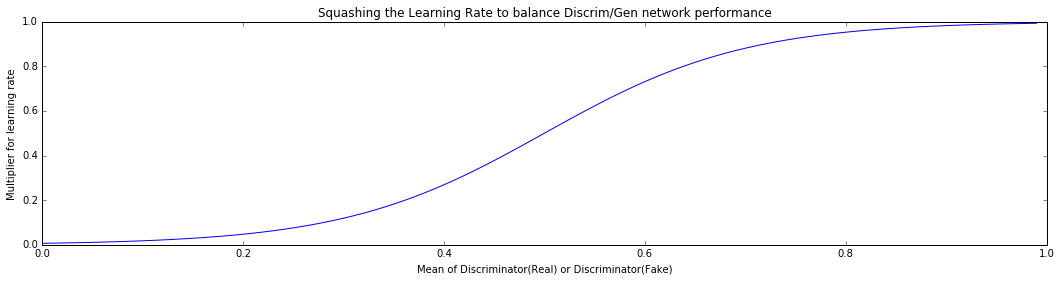

In [27]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(18,4))
plt.plot(np.arange(0,1,.01), [sigmoid(i/100.,-.5,10) for i in range(100)])
ax.set_xlabel('Mean of Discriminator(Real) or Discriminator(Fake)')
ax.set_ylabel('Multiplier for learning rate')
plt.title('Squashing the Learning Rate to balance Discrim/Gen network performance')

Epoch: 46


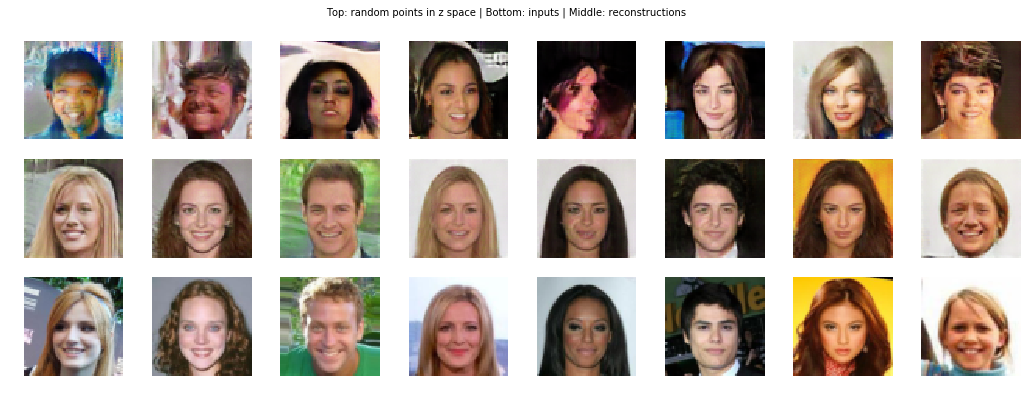

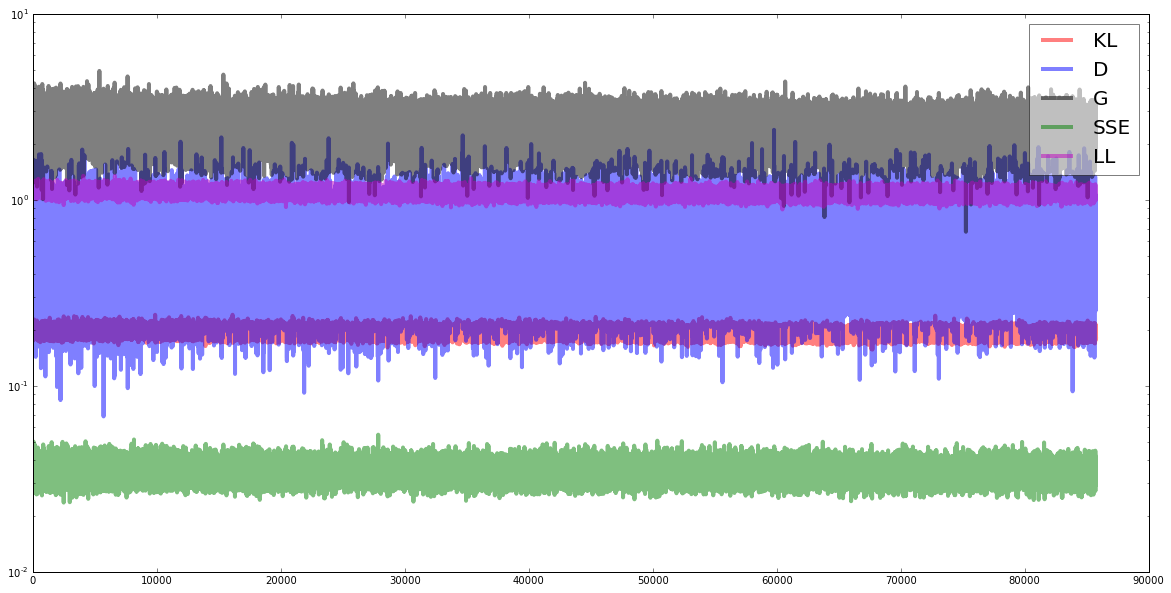

In [71]:
total_batch = int(np.floor(num_examples / batch_size*num_gpus)) # how many batches are in an epoch

# We balance of generator and discriminators learning rate by using a sigmoid function,
#  encouraging the generator and discriminator be about equal
d_real = 0
d_fake = 0

while epoch < num_epochs:    
    for i in tqdm.tqdm(range(total_batch)):
        iter_ = data_iterator()
        # balence gen and descrim
        e_current_lr = e_learning_rate*sigmoid(np.mean(d_real),-.5,15)
        g_current_lr = g_learning_rate*sigmoid(np.mean(d_real),-.5,15)
        d_current_lr = d_learning_rate*sigmoid(np.mean(d_fake),-.5,15)
        next_batches, _ = iter_.next()

        _, _, _, D_err, G_err, KL_err, SSE_err, LL_err, d_fake,d_real = sess.run([
                train_E, train_G, train_D,
                D_loss, G_loss, KL_loss, SSE_loss, LL_loss,
                d_x_p, d_x,

            ],
                                        {
                lr_E: e_current_lr,
                lr_G: g_current_lr,
                lr_D: d_current_lr,
                all_input: next_batches,
                KL_param: 1,
                G_param: 1,
                LL_param: 1
            }
       )
        #KL_err= SSE_err= LL_err = 1
        # Save our lists
        dxp_list.append(d_fake)
        dx_list.append(d_real)
        G_loss_list.append(G_err)
        D_loss_list.append(D_err)
        KL_loss_list.append(KL_err)
        SSE_loss_list.append(SSE_err)
        LL_loss_list.append(LL_err)
    
        if i%300 == 0:
            # print display network output
            IPython.display.clear_output()
            print('Epoch: '+str(epoch))
            plot_network_output()
  
    # save network
    saver.save(sess,''.join(['models/faces_multiGPU_64_',str(epoch).zfill(4),'.tfmod']))
    epoch +=1


### This is how we save our network 
- Just uncomment, and name it.

In [29]:
#saver.save(sess,''.join(['models/faces_multiGPU_64_',str(epoch).zfill(4),'.tfmod']))

### Visualize movement through z-space
- we're using jupyter widgets to slide through z-space from one point to another

In [30]:
n_steps = 20
examples = 10
all_x_recon = np.zeros((batch_size, dim1*dim2*dim3,n_steps))
z_point_a= np.random.normal(0,1,(batch_size,hidden_size))
z_point_b= np.random.normal(0,1,(batch_size,hidden_size))
recon_z_step = (z_point_b - z_point_a)/n_steps
for i in range(n_steps):
    z_point_a += recon_z_step
    all_x_recon[:,:,i] = sess.run((x_tilde), {z_x: z_point_a})

canvas = np.zeros((dim1,dim2*examples,dim3, n_steps))
print np.shape(canvas)
for f in range(n_steps):
    for i in range(examples):
        canvas[:,dim2*i:dim2*(i+1),:,f] = create_image(all_x_recon[i,:,f])
    

(64, 640, 3, 20)


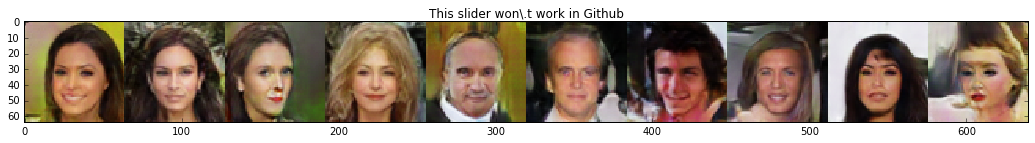

<function __main__.plt_random_faces>

In [40]:
def plt_random_faces(f):
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(18,12))
    plt.imshow(canvas[:,:,:,f],interpolation='nearest')
    plt.title('This slider won\.t work in Github')
    plt.show()
interact(plt_random_faces, f = (0,n_steps-1,1))

### 'Spike Triggered Average' style receptive fields.
- We take a look at what makes a neuron respond, by taking a bunch of images, and averaging them based on how much the neuron was activated. 

In [32]:
def norm(x):
    return (x - np.min(x)) / np.max(x - np.min(x))

In [33]:
# get a bunch of images and their corresponding z points in the network
recon_z = np.random.normal(0,1,(batch_size,hidden_size))
recon_x, recon_l = sess.run((x_tilde, l_x_tilde), {z_x: recon_z})
for i in range(100):
    rz = np.random.normal(0,1,(batch_size,hidden_size))
    rx, rl = sess.run((x_tilde, l_x_tilde), {z_x: rz})
    recon_z= np.concatenate((recon_z,rz),axis = 0)
    recon_l = np.concatenate((recon_l,rl),axis = 0)
    recon_x = np.concatenate((recon_x,rx),axis = 0)

#### Z-Neurons

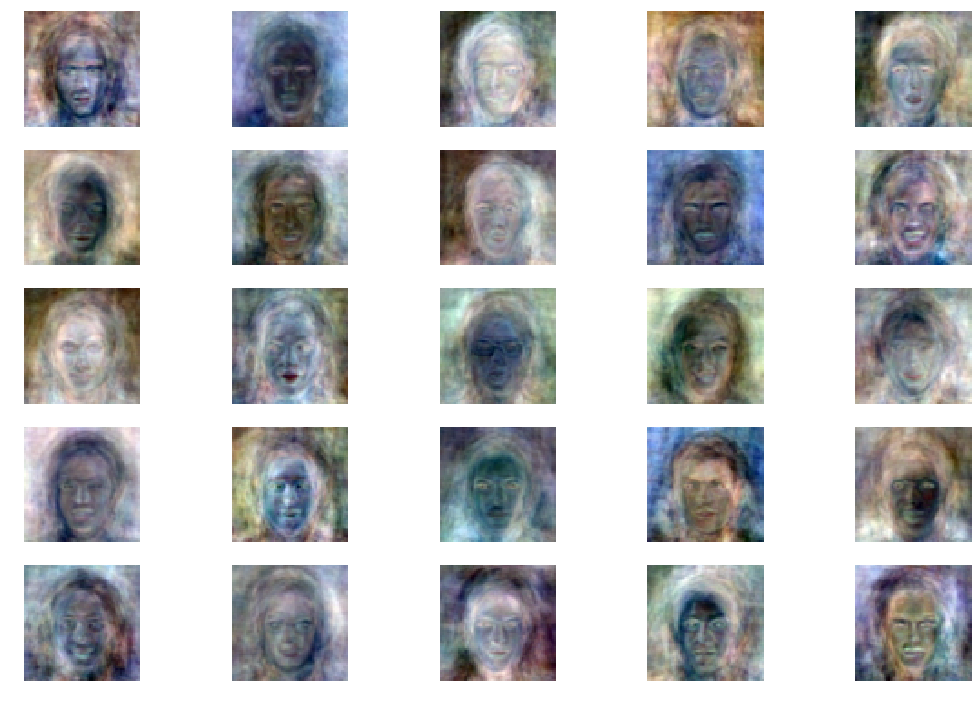

In [34]:
num_neurons = 25

neuron = 0
fig, ax = plt.subplots(nrows=int(np.sqrt(num_neurons)),ncols=int(np.sqrt(num_neurons)), figsize=(18,12))
for a in range(int(np.sqrt(num_neurons))):
    for b in range(int(np.sqrt(num_neurons))):
        proportions = (recon_z[:,neuron] - min(recon_z[:,neuron])) / max((recon_z[:,neuron] - min(recon_z[:,neuron])))
        receptive_field = norm(np.sum(([proportions[i] * recon_x[i,:] for i in range(len(proportions))]),axis = 0)/np.sum(proportions)- np.mean(recon_x,axis = 0))
        ax[(a,b)].imshow(create_image(receptive_field), cmap=plt.cm.gray, interpolation='nearest')
        ax[(a,b)].axis('off')
        neuron+=1

#### Deep Descriminator Neurons

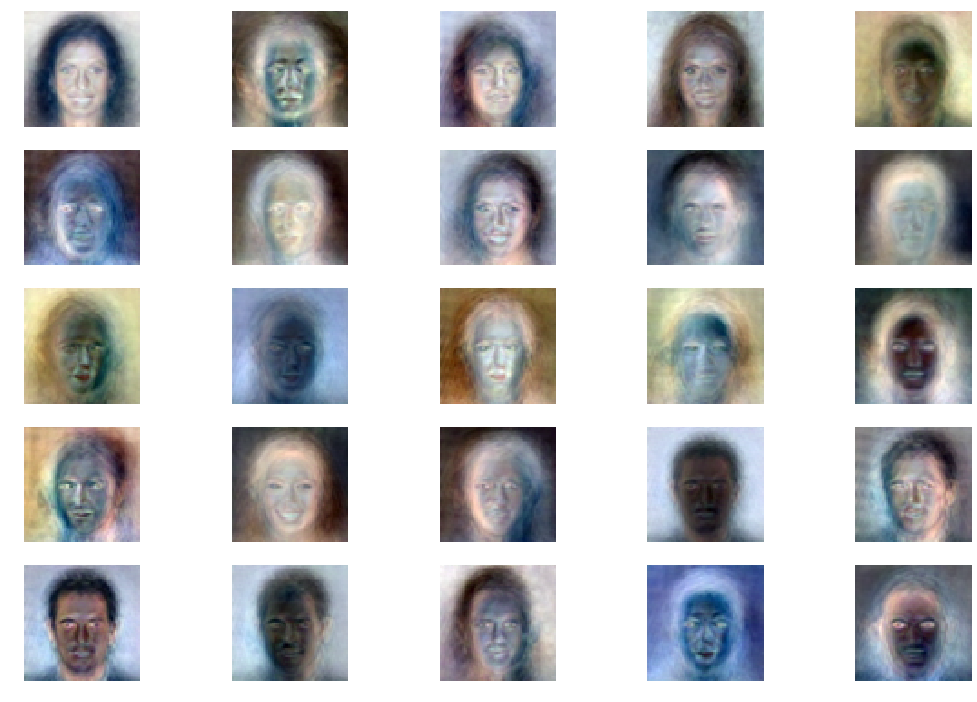

In [35]:
num_neurons = 25

neuron = 0
fig, ax = plt.subplots(nrows=int(np.sqrt(num_neurons)),ncols=int(np.sqrt(num_neurons)), figsize=(18,12))
for a in range(int(np.sqrt(num_neurons))):
    for b in range(int(np.sqrt(num_neurons))):
        proportions = (recon_l[:,neuron] - min(recon_l[:,neuron])) / max((recon_l[:,neuron] - min(recon_l[:,neuron])))
        receptive_field = norm(np.sum(([proportions[i] * recon_x[i,:] for i in range(len(proportions))]),axis = 0)/np.sum(proportions)- np.mean(recon_x,axis = 0))
        #test = norm(test/np.mean(test_list, axis = 0))
        ax[(a,b)].imshow(create_image(receptive_field), cmap=plt.cm.gray, interpolation='nearest')
        ax[(a,b)].axis('off')
        neuron+=1

### Now lets try some latent space algebra

In [36]:
# Here are the attribute types
print [str(i) + ': ' + headers[i] for i in range(len(headers))]

['0: 5_o_Clock_Shadow', '1: Arched_Eyebrows', '2: Attractive', '3: Bags_Under_Eyes', '4: Bald', '5: Bangs', '6: Big_Lips', '7: Big_Nose', '8: Black_Hair', '9: Blond_Hair', '10: Blurry', '11: Brown_Hair', '12: Bushy_Eyebrows', '13: Chubby', '14: Double_Chin', '15: Eyeglasses', '16: Goatee', '17: Gray_Hair', '18: Heavy_Makeup', '19: High_Cheekbones', '20: Male', '21: Mouth_Slightly_Open', '22: Mustache', '23: Narrow_Eyes', '24: No_Beard', '25: Oval_Face', '26: Pale_Skin', '27: Pointy_Nose', '28: Receding_Hairline', '29: Rosy_Cheeks', '30: Sideburns', '31: Smiling', '32: Straight_Hair', '33: Wavy_Hair', '34: Wearing_Earrings', '35: Wearing_Hat', '36: Wearing_Lipstick', '37: Wearing_Necklace', '38: Wearing_Necktie', '39: Young']


In [50]:
# Go through a bunch of inputs, get their z values and their attributes
iter_ = data_iterator()
all_batch, all_attrib = iter_.next()
all_z = sess.run((z_x_mean), {all_input: all_batch})
all_recon_x = sess.run((x_tilde), {z_x: all_z})

for i in range(200):
    next_batch, next_attrib = iter_.next()
    recon_z = sess.run((z_x_mean), {all_input: next_batch})
    recon_x = sess.run((x_tilde), {z_x: recon_z})

    all_z = np.concatenate((all_z,recon_z),axis = 0)
    all_batch = np.concatenate((all_batch,next_batch),axis = 0)
    all_recon_x = np.concatenate((all_recon_x,recon_x),axis = 0)
    all_attrib = np.concatenate((all_attrib,next_attrib),axis = 0)       

In [51]:
# for each attribute type, get the difference between the mean z-vector of faces with
#   the attribute, and without the attribute
attr_vector_list = []
avg_attr_list = []
avg_not_attr_list = []

for i in range(np.shape(all_attrib)[1]):
    has_attribute = all_attrib[:,i] == 1
    average_attribute = np.mean(all_z[has_attribute], axis=0)
    average_not_attribute = np.mean(all_z[has_attribute == False], axis=0)
    avg_attr_list.append(average_attribute)
    avg_not_attr_list.append(average_not_attribute)
    attr_vector_list.append(average_attribute - average_not_attribute)

In [52]:
feature_to_look_at = 9 # specify the attribute we want to look at

#### Look at some blonde people (bottom), and their reconstructions (top)

(-0.5, 255.5, 127.5, -0.5)

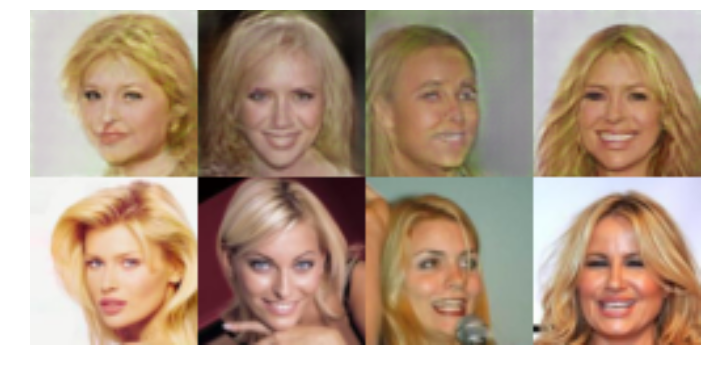

In [53]:
# show some faces which have this attribute
recon_faces = all_recon_x[all_attrib[:,feature_to_look_at] == 1,:]
new_faces = all_batch[all_attrib[:,feature_to_look_at] == 1,:]

examples = 4
canvas = np.zeros((dim1*2,dim2*examples,dim3))
for i in range(examples):
    canvas[0:dim1,dim2*i:dim2*(i+1),:] = create_image(recon_faces[i])
    canvas[dim1:,dim2*i:dim2*(i+1),:] = create_image(new_faces[i])
    
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(18,6))
ax.imshow(canvas)
ax.axis('off')

#### Take random z-points, and add the blonde vector

In [76]:
recon_z = np.random.normal(0,1,(batch_size,hidden_size))
recon_x = sess.run((x_tilde), {z_x: recon_z})

In [77]:
recon_z_with_attribute = [recon_z[i] + attr_vector_list[feature_to_look_at] for i in range(len(recon_z))]
recon_x_with_attribute = sess.run((x_tilde), {z_x: recon_z_with_attribute})

In [78]:
examples = 12
canvas = np.zeros((dim1*2,dim2*examples,dim3))
for i in range(examples):
    canvas[:dim1,dim2*i:dim2*(i+1),:] = create_image(recon_x[i])
    canvas[dim1:,dim2*i:dim2*(i+1),:] = create_image(recon_x_with_attribute[i])

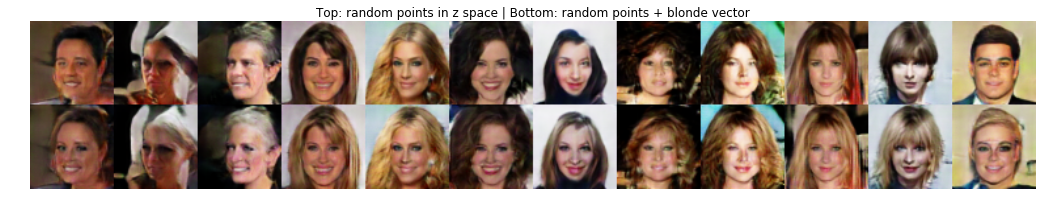

In [79]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(18,6))
ax.imshow(canvas)
ax.axis('off')
plt.title('Top: random points in z space | Bottom: random points + blonde vector')

#### Look at the average blonde person, the average not blonde person, and their difference

In [58]:
recon_z = np.random.normal(0,1,(batch_size,hidden_size))
recon_z[0] = avg_attr_list[feature_to_look_at]
recon_z[1] = avg_not_attr_list[feature_to_look_at]
recon_z[2] = attr_vector_list[feature_to_look_at]

recon_x = sess.run((x_tilde), {z_x: recon_z})

In [59]:
examples = 3
canvas = np.zeros((dim1,dim2*examples,dim3))
for i in range(examples):
    canvas[:,dim2*i:dim2*(i+1),:] = create_image(recon_x[i])

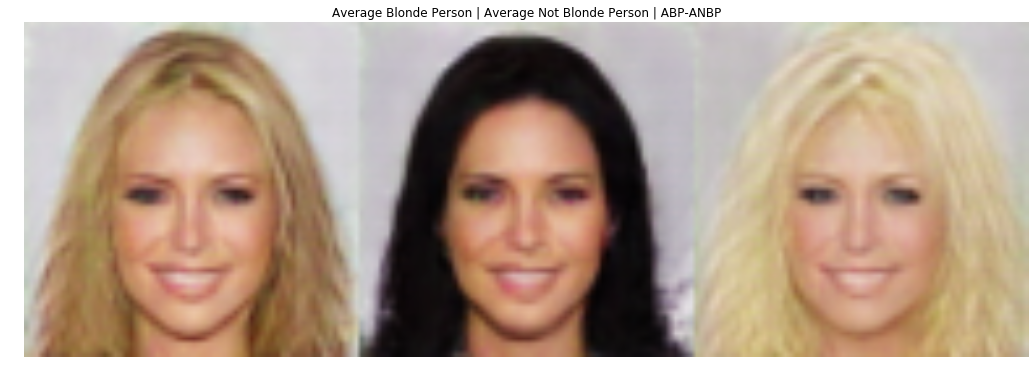

In [60]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(18,6))
ax.imshow(canvas)
ax.axis('off')
plt.title('Average Blonde Person | Average Not Blonde Person | ABP-ANBP')

### This implementation is based on a few other things:
- [Autoencoding beyond pixels](http://arxiv.org/abs/1512.09300) [*(Github)*](https://github.com/andersbll/autoencoding_beyond_pixels)
- [VAE and GAN implementations in prettytensor/tensorflow (*Github*)](https://github.com/ikostrikov/TensorFlow-VAE-GAN-DRAW)
- [Tensorflow VAE tutorial](https://jmetzen.github.io/2015-11-27/vae.html)
- [DCGAN](https://arxiv.org/abs/1511.06434) [*(Github)*](https://github.com/Newmu/dcgan_code)
- [Torch GAN tutorial](http://torch.ch/blog/2015/11/13/gan.html) [*(Github)*](https://github.com/skaae/torch-gan)
- [Open AI improving GANS](https://openai.com/blog/generative-models/)  [*(Github)*](https://github.com/openai/improved-gan)
- Other things which I am probably forgetting...


In [84]:
# this is just a little command to convert this as md for the github page
!jupyter nbconvert --to markdown VAE-GAN-multi-gpu-celebA.ipynb
!mv VAE-GAN-multi-gpu-celebA.md readme.md

[NbConvertApp] Converting notebook VAE-GAN-multi-gpu-celebA.ipynb to markdown
[NbConvertApp] Support files will be in VAE-GAN-multi-gpu-celebA_files/
[NbConvertApp] Making directory VAE-GAN-multi-gpu-celebA_files
[NbConvertApp] Making directory VAE-GAN-multi-gpu-celebA_files
[NbConvertApp] Making directory VAE-GAN-multi-gpu-celebA_files
[NbConvertApp] Making directory VAE-GAN-multi-gpu-celebA_files
[NbConvertApp] Making directory VAE-GAN-multi-gpu-celebA_files
[NbConvertApp] Making directory VAE-GAN-multi-gpu-celebA_files
[NbConvertApp] Making directory VAE-GAN-multi-gpu-celebA_files
[NbConvertApp] Making directory VAE-GAN-multi-gpu-celebA_files
[NbConvertApp] Making directory VAE-GAN-multi-gpu-celebA_files
[NbConvertApp] Making directory VAE-GAN-multi-gpu-celebA_files
[NbConvertApp] Making directory VAE-GAN-multi-gpu-celebA_files
[NbConvertApp] Making directory VAE-GAN-multi-gpu-celebA_files
[NbConvertApp] Writing 34120 bytes to VAE-GAN-multi-gpu-celebA.md
